# Import Library


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [49]:
df = pd.read_csv('Car_data.csv')
df.head()

,Series,Observation Date,Observation Value
0,Sales of Cars and Jeeps,30-Sep-23,7859
1,Sales of Cars and Jeeps,31-Aug-23,7283
2,Sales of Cars and Jeeps,31-Jul-23,4752
3,Sales of Cars and Jeeps,30-Jun-23,5764
4,Sales of Cars and Jeeps,31-May-23,5198


In [50]:
df.tail()

,Series,Observation Date,Observation Value
268,Sales of Cars and Jeeps,31-May-01,3873
269,Sales of Cars and Jeeps,30-Apr-01,3503
270,Sales of Cars and Jeeps,31-Mar-01,3749
271,Sales of Cars and Jeeps,28-Feb-01,3943
272,Sales of Cars and Jeeps,31-Jan-01,3669


In [51]:
df['Observation Date'] = pd.to_datetime(df['Observation Date'], format='%d-%b-%y')


In [52]:
df_sorted = df.sort_values(by='Observation Date')

In [53]:
df_sorted.head()

,Series,Observation Date,Observation Value
272,Sales of Cars and Jeeps,2001-01-31,3669
271,Sales of Cars and Jeeps,2001-02-28,3943
270,Sales of Cars and Jeeps,2001-03-31,3749
269,Sales of Cars and Jeeps,2001-04-30,3503
268,Sales of Cars and Jeeps,2001-05-31,3873


In [54]:
df_sorted.tail()

,Series,Observation Date,Observation Value
4,Sales of Cars and Jeeps,2023-05-31,5198
3,Sales of Cars and Jeeps,2023-06-30,5764
2,Sales of Cars and Jeeps,2023-07-31,4752
1,Sales of Cars and Jeeps,2023-08-31,7283
0,Sales of Cars and Jeeps,2023-09-30,7859


In [55]:
df_sorted = df_sorted.drop(columns= 'Series')
df_sorted.head()

,Observation Date,Observation Value
272,2001-01-31,3669
271,2001-02-28,3943
270,2001-03-31,3749
269,2001-04-30,3503
268,2001-05-31,3873


In [56]:
df_sorted.tail()

,Observation Date,Observation Value
4,2023-05-31,5198
3,2023-06-30,5764
2,2023-07-31,4752
1,2023-08-31,7283
0,2023-09-30,7859


# EDA

In [57]:
df_sorted.shape

(273, 2)

In [58]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 272 to 0
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Observation Date   273 non-null    datetime64[ns]
 1   Observation Value  273 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [59]:
df_sorted.rename(columns={'Observation Date': 'Date'}, inplace=True)
df_sorted.rename(columns={'Observation Value': 'Value'}, inplace=True)

Text(0, 0.5, 'Num of Values')

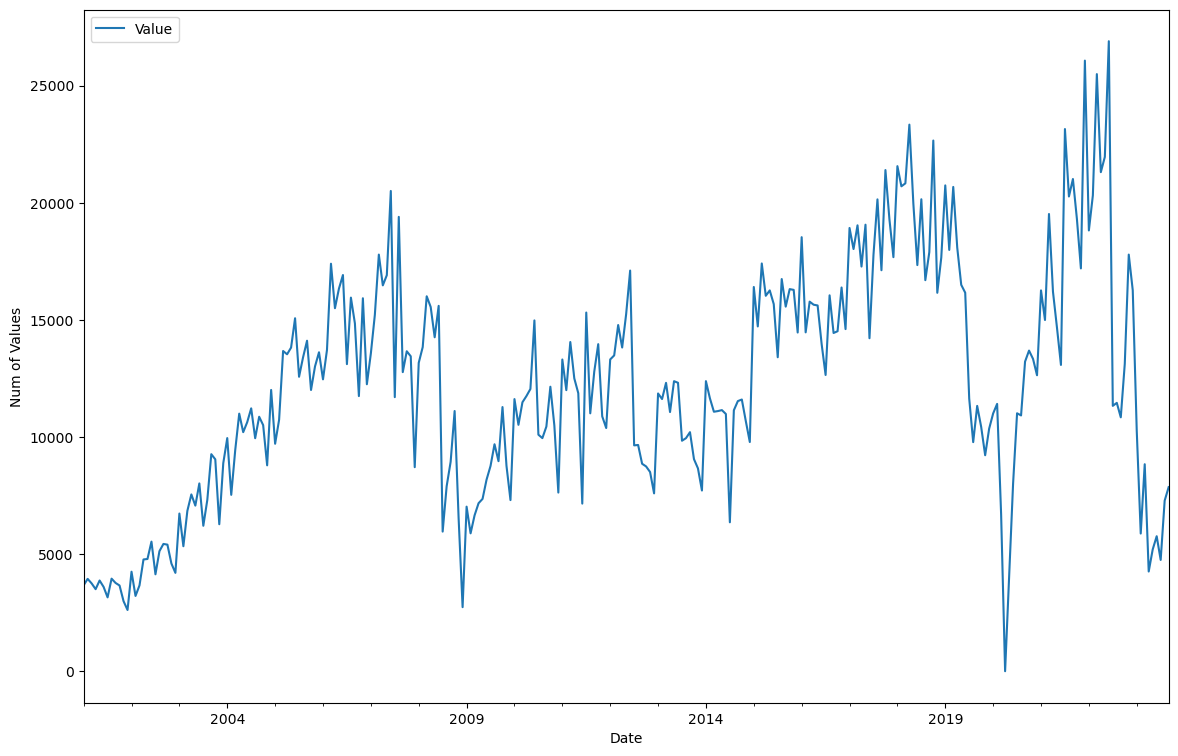

In [60]:
# Plot the data

df_sorted.columns = ['Date', 'Value']
df_sorted.Date = pd.to_datetime(df_sorted.Date)
df_sorted.set_index('Date',inplace=True)
df_sorted.plot()
plt.xlabel('Date')
plt.ylabel('Num of Values')

In [61]:
df_sorted.head()

,Value
Date,
2001-01-31,3669
2001-02-28,3943
2001-03-31,3749
2001-04-30,3503
2001-05-31,3873


# Check Stationarity

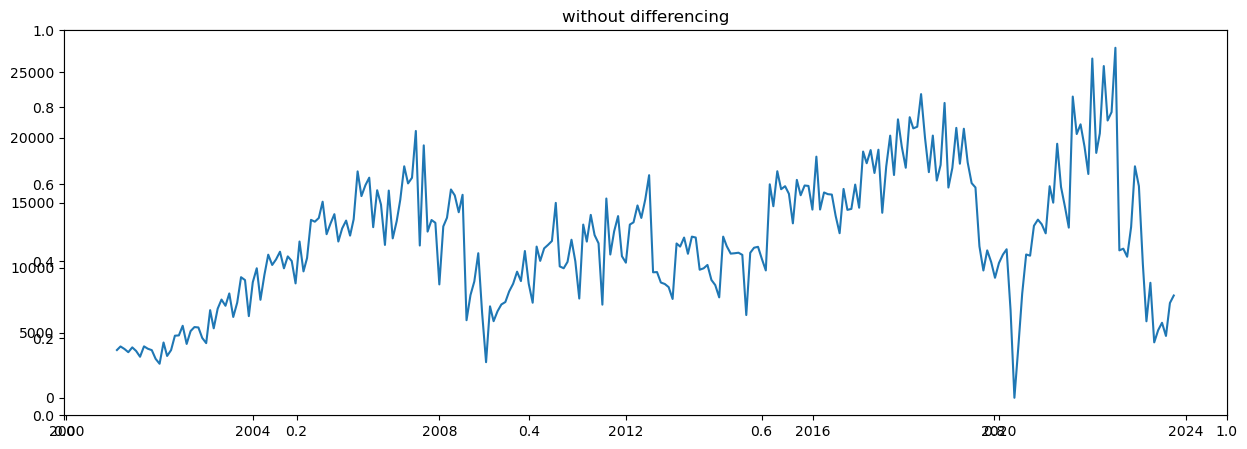

In [62]:
# Plot without differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('without differencing')
ax1.plot(df_sorted['Value'])

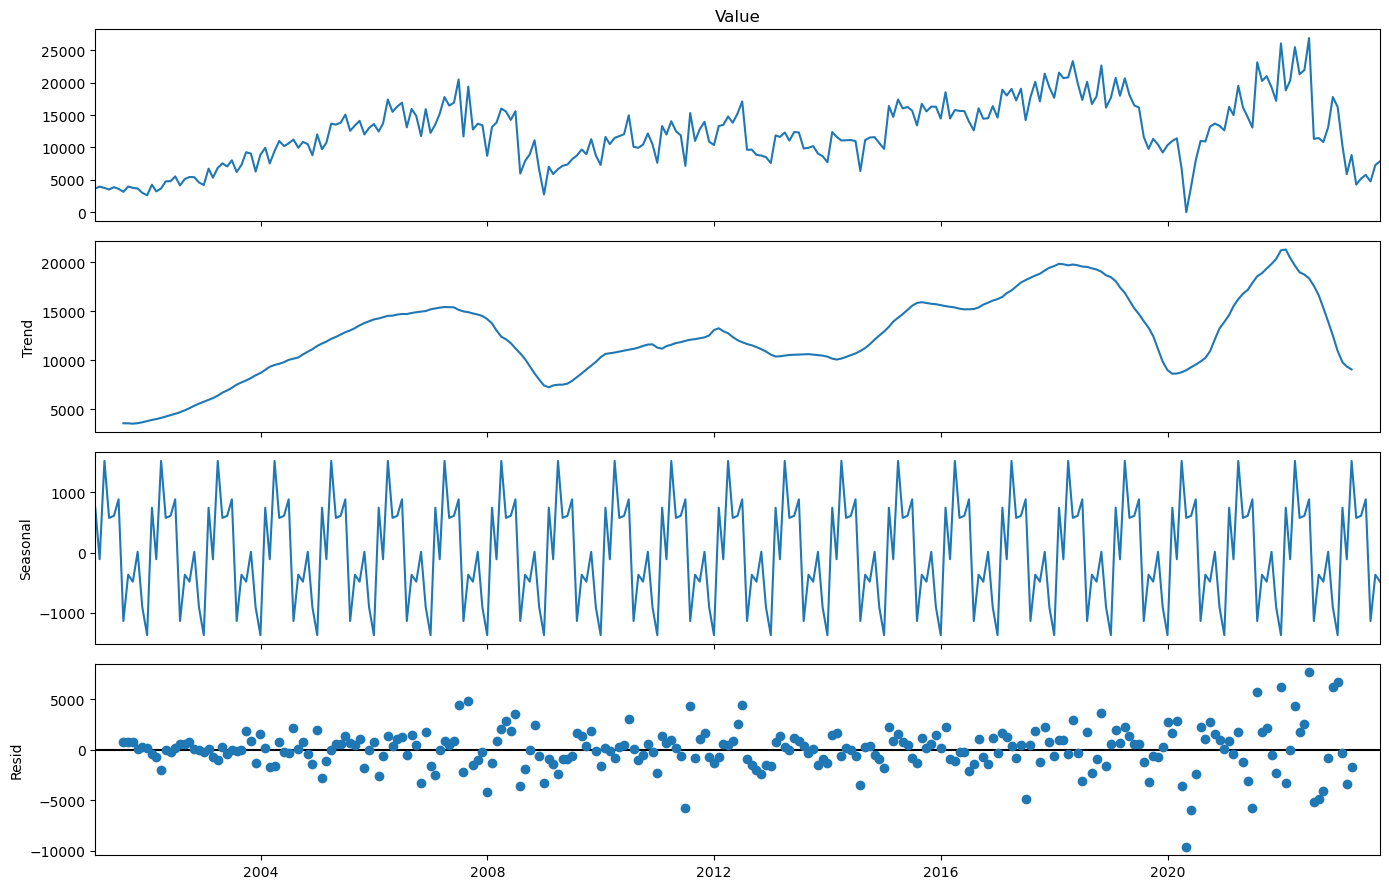

In [63]:
# Decompose the components from the time series.

import pylab
from statsmodels.tsa.seasonal import seasonal_decompose

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_sorted['Value'], model='additive')
ax=res.plot()
plt.show()

In [64]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [65]:
# Check stationarity of the dataset

check_stationarity(df_sorted['Value'])

ADF Statistic: -3.492987
p-value: 0.008169
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Stationary


In [66]:
# Check stationarity of the dataset

check_stationarity(df_sorted['Value'].diff().diff().dropna())

ADF Statistic: -10.382467
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Stationary


In [67]:
df_sorted['Value'] = df_sorted['Value'].diff().diff().dropna()

# Modeling

In [68]:
# Splitting dataset

train = df_sorted[:137]
test = df_sorted[137:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (137, 1)
Test size :  (136, 1)


In [69]:
train = train.dropna()
train

,Value
Date,
2001-03-31,-468.0
2001-04-30,-52.0
2001-05-31,616.0
2001-06-30,-643.0
2001-07-31,-174.0
...,...
2012-01-31,3427.0
2012-02-29,-2755.0
2012-03-31,1123.0


In [70]:
test 

,Value
Date,
2012-06-30,429.0
2012-07-31,-9320.0
2012-08-31,7480.0
2012-09-30,-819.0
2012-10-31,688.0
...,...
2023-05-31,5521.0
2023-06-30,-375.0
2023-07-31,-1578.0


In [71]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [72]:
# Stationarity check

check_stationarity(train['Value'])

ADF Statistic: -7.852872
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Stationary


In [73]:
# First-order differencing

check_stationarity(train['Value'].diff().dropna())

ADF Statistic: -8.079353
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Stationary


In [74]:
train

,Value
Date,
2001-03-31,-468.0
2001-04-30,-52.0
2001-05-31,616.0
2001-06-30,-643.0
2001-07-31,-174.0
...,...
2012-01-31,3427.0
2012-02-29,-2755.0
2012-03-31,1123.0


# **Naive Approach**

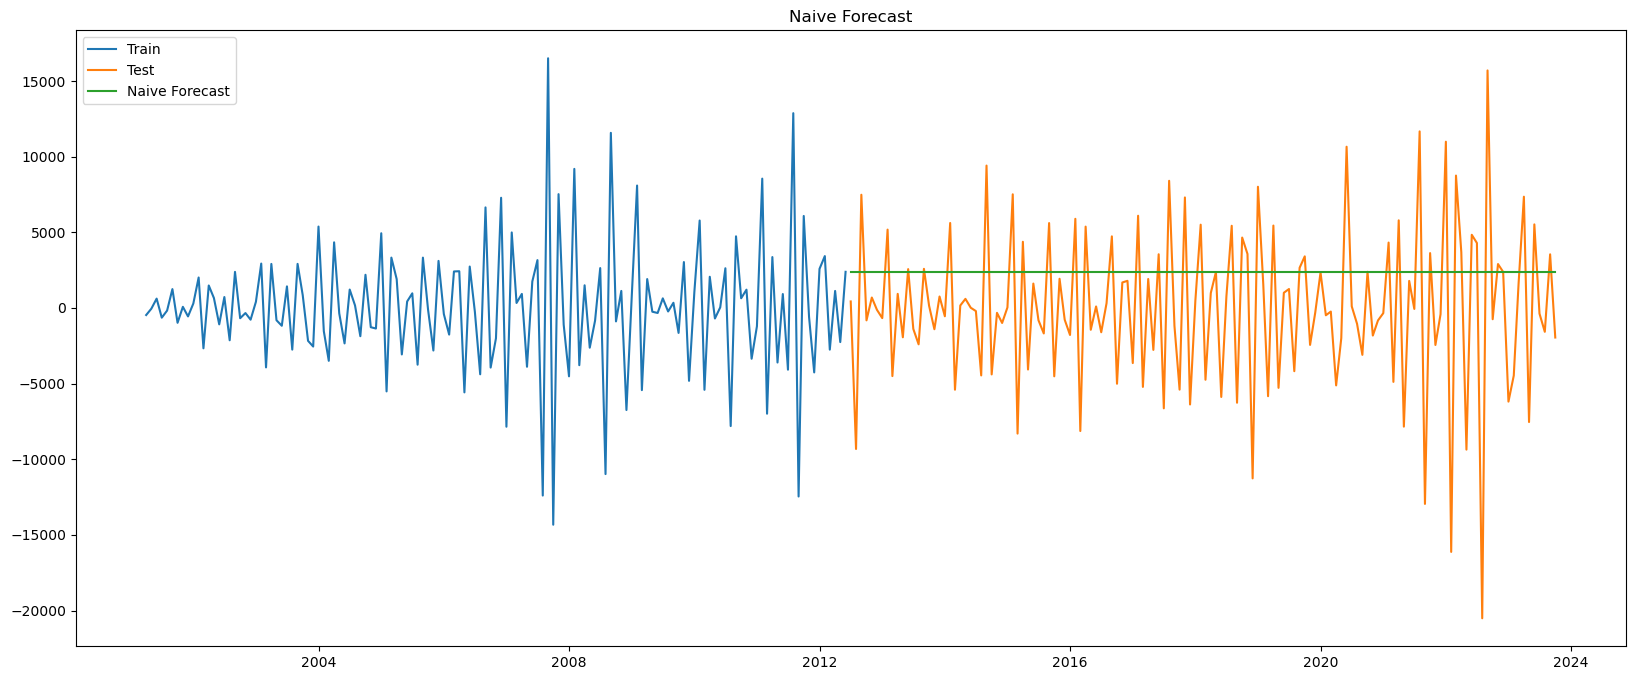

In [75]:
dd= np.asarray(train.Value)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index,test['Value'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
rmse = sqrt(mean_squared_error(test.Value, y_hat.naive))
mae = mean_absolute_error(test.Value, y_hat.naive)

print("mae :",mae)
print("rmse :",rmse)

mae : 4464.294117647059
rmse : 5821.139365683138


# **Simple Average**

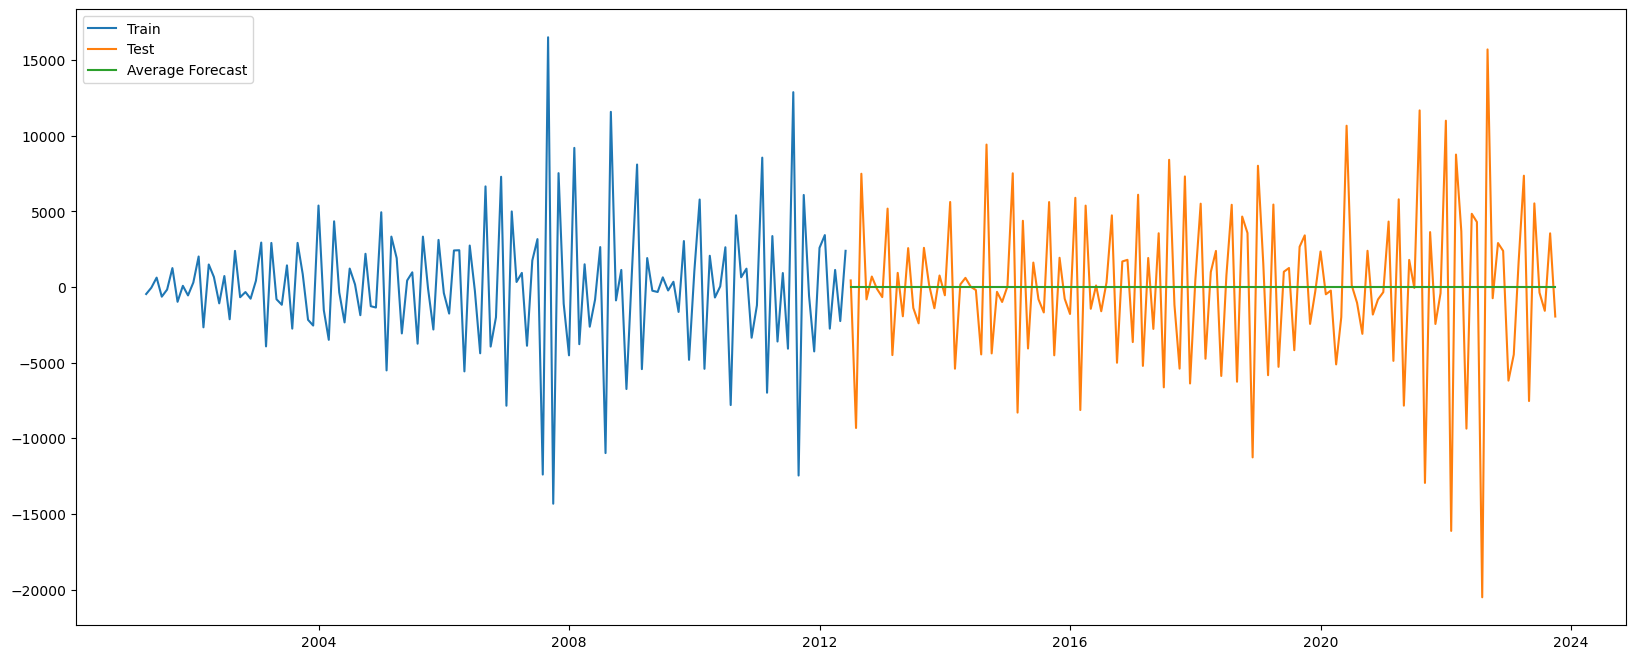

In [77]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Value'].mean()
plt.figure(figsize=(20,8))
plt.plot(train['Value'], label='Train')
plt.plot(test['Value'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [78]:
print("mae :", mean_absolute_error(test.Value, y_hat_avg.avg_forecast))
print("rmse :", sqrt(mean_squared_error(test.Value, y_hat_avg.avg_forecast)))

mae : 3918.8382352941176
rmse : 5306.426950682377


# **Moving Average**

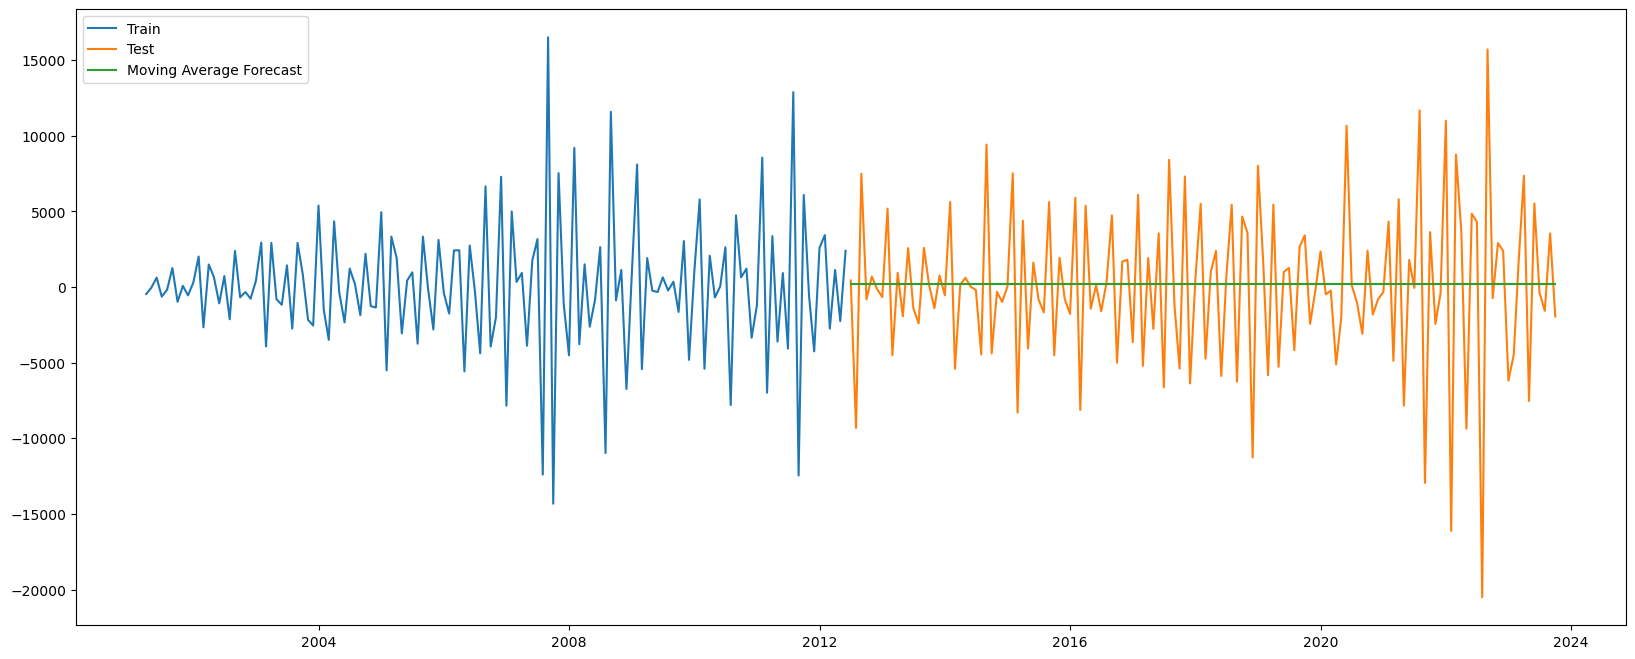

In [79]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Value'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(20,8))
plt.plot(train['Value'], label='Train')
plt.plot(test['Value'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [80]:
print("mae :", mean_absolute_error(test.Value, y_hat_avg.moving_avg_forecast))
print("rmse :", sqrt(mean_squared_error(test.Value, y_hat_avg.moving_avg_forecast)))

mae : 3925.7279411764707
rmse : 5309.391377342051


# **SES**

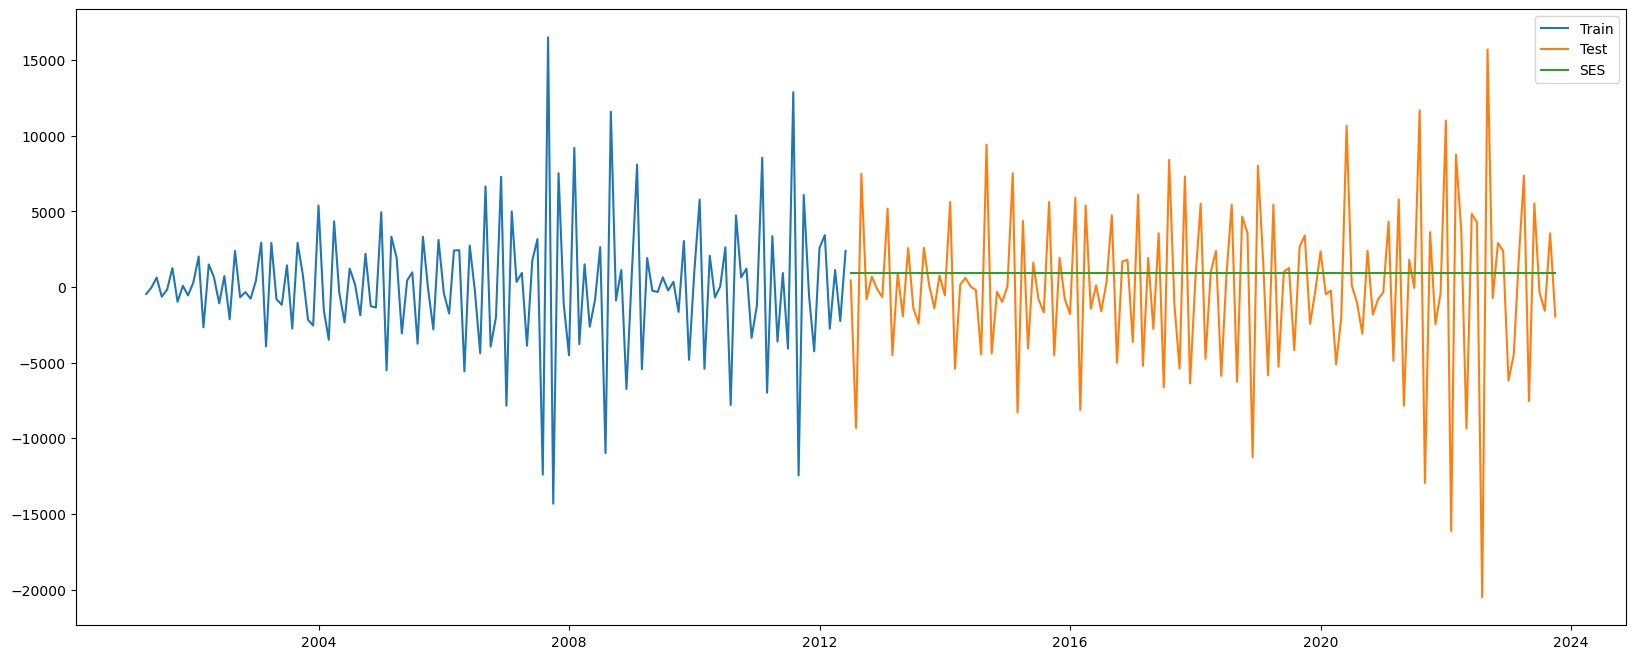

In [81]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Value'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['Value'], label='Train')
plt.plot(test['Value'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [82]:
print("mae :", mean_absolute_error(test.Value, y_hat_avg.SES))
print("rmse :", sqrt(mean_squared_error(test.Value, y_hat_avg.SES)))

mae : 4033.6389034429903
rmse : 5392.166408242194


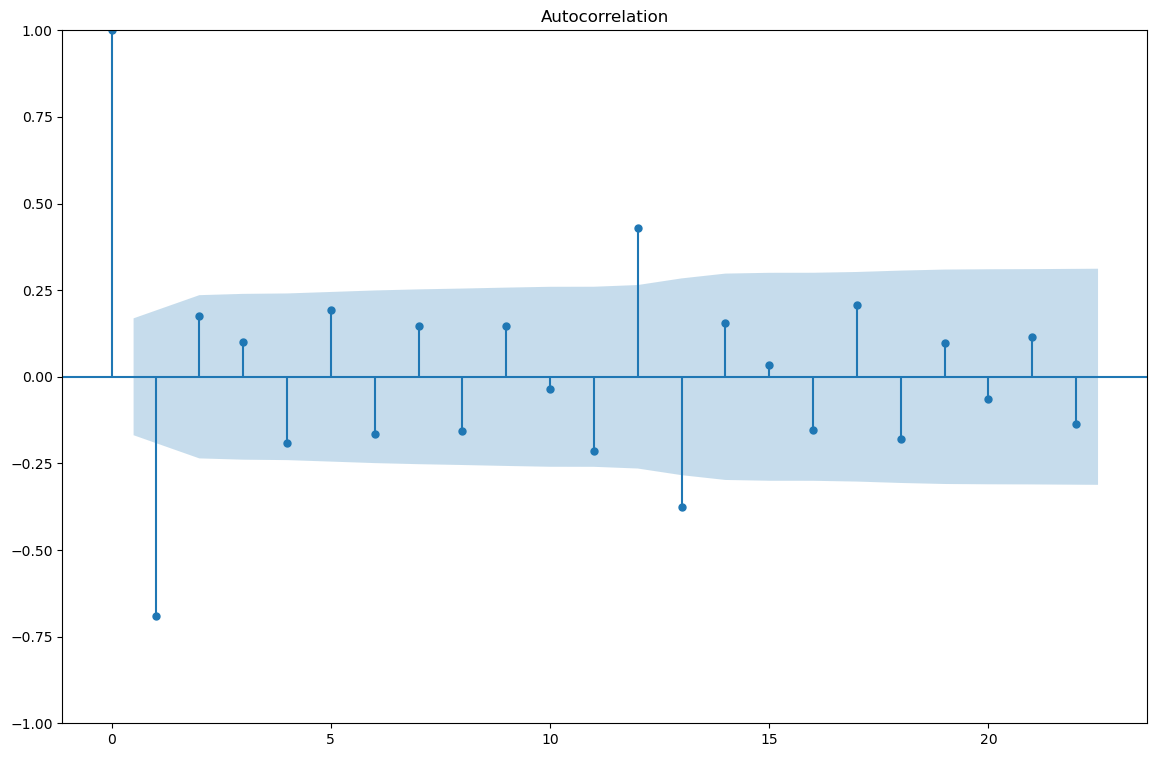

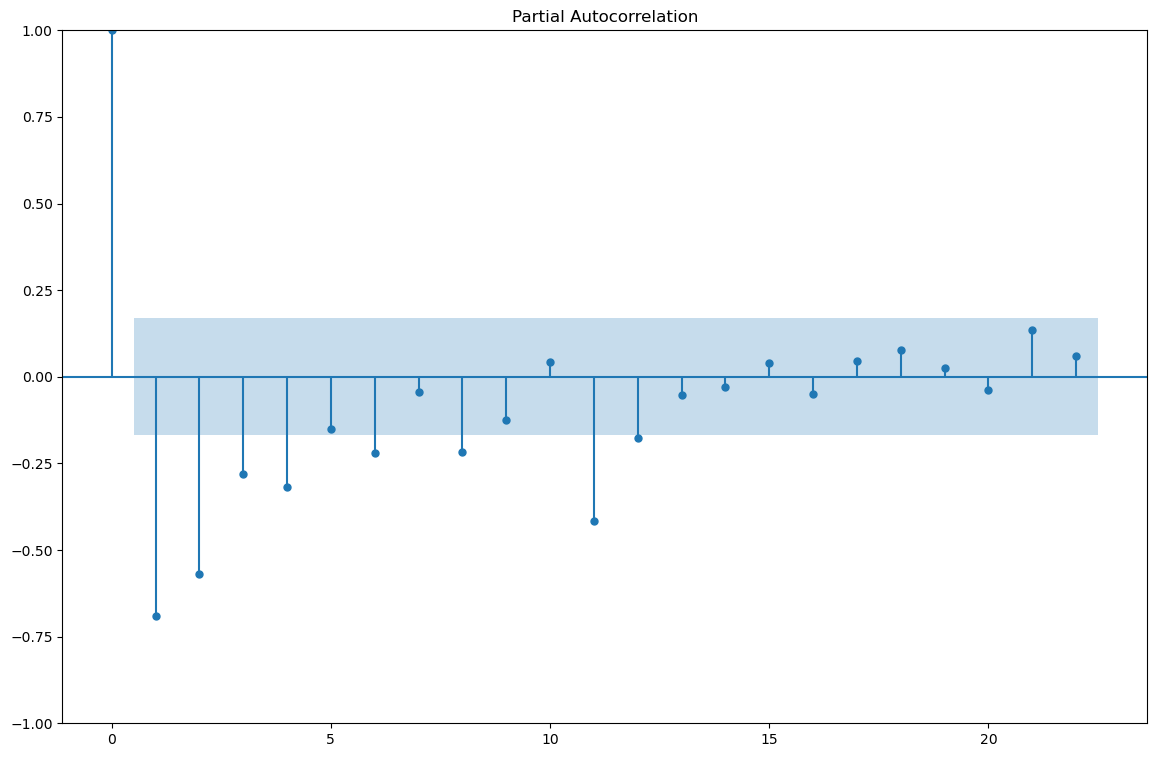

In [83]:
# Check plot ACF & PACF

plot_acf(train['Value'])
plot_pacf(train['Value'])
plt.show()

In [84]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [85]:
# Find best model of ARIMA with combinations of p=4, d=4, q=4
find_best_model(train['Value'], 4, 4, 4)

(3,
 3,
 1,
 10.0,
     p  d  q          AIC
 90  3  3  1    10.000000
 8   0  1  3  2459.619958
 33  1  1  3  2459.740693
 9   0  1  4  2459.789345
 57  2  1  3  2461.393339
 .. .. .. ..          ...
 40  1  3  0  2944.013979
 21  0  4  1  3073.791512
 45  1  4  0  3078.720319
 15  0  3  0  3089.428437
 20  0  4  0  3236.181960
 
 [123 rows x 4 columns])

In [96]:
# Train ARIMA with best combinations

model_arima_234 = ARIMA(train['Value'], order=(3, 3, 1))
result_model_arima_234 = model_arima_234.fit()
print('The AIC is ', result_model_arima_234.aic)

The AIC is  10.0


In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np

# Assuming 'test' is your test dataset and it has a column 'Value' with the actual values

# Step 1: Predict the values using the fitted model for the length of the test set
# The forecast method's output depends on the statsmodels version
# We'll use the get_prediction and summary_frame functions for compatibility
forecast_results = result_model_arima_234.get_prediction(start=len(train), end=len(train)+len(test)-1)
predicted_mean = forecast_results.predicted_mean

# Step 2: Compare the predicted values with the actual values
actual_values = test['Value'].values  # Ensure this is an array

# Step 3: Calculate the MAE and RMSE
mae = mean_absolute_error(actual_values, predicted_mean)
rmse = sqrt(mean_squared_error(actual_values, predicted_mean))

print('The MAE is', mae)
print('The RMSE is', rmse)


The MAE is 5012647.607175999
The RMSE is 5344202.992107497


# F. SARIMA

In [88]:
# Splitting dataset

trains = df_sorted[:137]
tests = df_sorted[137:]

print('Train size : ', trains.shape)
print('Test size : ', tests.shape)

Train size :  (137, 1)
Test size :  (136, 1)


In [89]:
trains

,Value
Date,
2001-01-31,NaN
2001-02-28,NaN
2001-03-31,-468.0
2001-04-30,-52.0
2001-05-31,616.0
...,...
2012-01-31,3427.0
2012-02-29,-2755.0
2012-03-31,1123.0


In [90]:
tests

,Value
Date,
2012-06-30,429.0
2012-07-31,-9320.0
2012-08-31,7480.0
2012-09-30,-819.0
2012-10-31,688.0
...,...
2023-05-31,5521.0
2023-06-30,-375.0
2023-07-31,-1578.0


In [91]:
# Train using SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

sar=SARIMAX(trains['Value'], order=(2, 2, 2),seasonal_order=(2, 2, 2, 12)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  137
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1104.956
Date:                            Wed, 22 Nov 2023   AIC                           2227.913
Time:                                    10:00:40   BIC                           2252.299
Sample:                                01-31-2001   HQIC                          2237.806
                                     - 05-31-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0540      0.428     -2.461      0.014      -1.893      -0.215
ar.L2         -0.5304      0.458     -1.157      0.247      -1.429       0.368
ma.L1         -1.8989      0.345     -5.504      0.000      -2.575      -1.223
ma.L2          0.9578      0.326      2.935      0.003       0.318       1.598
ar.S.L12       0.2399     67.697      0.004      0.997    -132.444     132.924
ar.S.L24       0.4291     37.926      0.011      0.991     -73.904      74.762
ma.S.L12      -1.3975     67.634     -0.021      0.984    -133.958     131.163
ma.S.L24       0.4905     40.719      0.012      0.990     -79.317      80.298
sigma2      5.527e+07      0.000   1.55e+11      0.000    5.53e+07    5.53e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.58   Jarque-Bera (JB):                16.23
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               4.27   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+27. Standard errors may be unstable.
"""

In [92]:
# Predict test-set

## Predict test-set
sar_pred_test = sar.predict(start= "2012-06-30", end="2023-09-30", dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['Sales_Car_predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([tests, sar_pred_test], axis=1)
act_vs_pred_sar

,Value,Sales_Car_predict
2012-06-30,429.0,-4213.768485
2012-07-31,-9320.0,9516.651608
2012-08-31,7480.0,-10646.659546
2012-09-30,-819.0,6607.713140
2012-10-31,688.0,-295.459230
...,...,...
2023-05-31,5521.0,-24543.000411
2023-06-30,-375.0,-60405.984266
2023-07-31,-1578.0,34093.380837
2023-08-31,3543.0,-106667.767601


In [93]:
# Check the MAE & RMSE

print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('RMSE test : ', np.sqrt(mean_squared_error(test, sar_pred_test)))

MAE test  :  18405.28221775556
RMSE test :  26480.70801839468


# **Naive Approach**

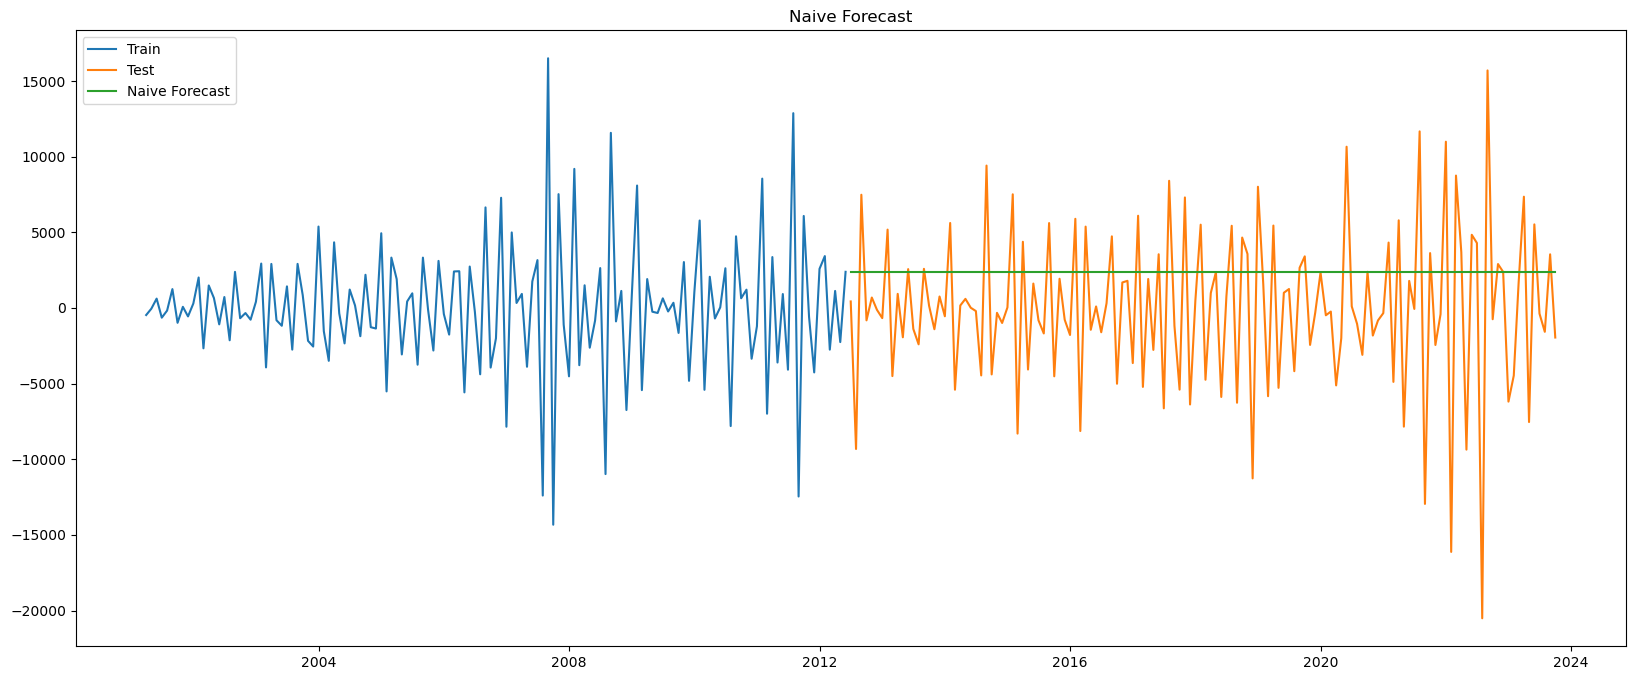

In [94]:
dd= np.asarray(train.Value)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index,test['Value'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()